In [1]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor, early_stopping, log_evaluation
import optuna
import seaborn as sns
from scipy.stats import boxcox
from sklearn.ensemble import VotingRegressor
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import logging
logging.getLogger("lightgbm").setLevel(logging.ERROR)

RANDOM_SEED = 2024


# Loading Data

In [ ]:
data_folder = "data"

In [3]:
train = pd.read_csv(os.path.join(data_folder, "train.csv"))
test = pd.read_csv(os.path.join(data_folder, "test.csv"))

In [4]:
train.head()

,id,Age,Gender,Annual Income,Marital Status,Number of Dependents,Education Level,Occupation,Health Score,Location,...,Previous Claims,Vehicle Age,Credit Score,Insurance Duration,Policy Start Date,Customer Feedback,Smoking Status,Exercise Frequency,Property Type,Premium Amount
0,0,19.0,Female,10049.0,Married,1.0,Bachelor's,Self-Employed,22.598761,Urban,...,2.0,17.0,372.0,5.0,2023-12-23 15:21:39.134960,Poor,No,Weekly,House,2869.0
1,1,39.0,Female,31678.0,Divorced,3.0,Master's,NaN,15.569731,Rural,...,1.0,12.0,694.0,2.0,2023-06-12 15:21:39.111551,Average,Yes,Monthly,House,1483.0
2,2,23.0,Male,25602.0,Divorced,3.0,High School,Self-Employed,47.177549,Suburban,...,1.0,14.0,NaN,3.0,2023-09-30 15:21:39.221386,Good,Yes,Weekly,House,567.0
3,3,21.0,Male,141855.0,Married,2.0,Bachelor's,NaN,10.938144,Rural,...,1.0,0.0,367.0,1.0,2024-06-12 15:21:39.226954,Poor,Yes,Daily,Apartment,765.0
4,4,21.0,Male,39651.0,Single,1.0,Bachelor's,Self-Employed,20.376094,Rural,...,0.0,8.0,598.0,4.0,2021-12-01 15:21:39.252145,Poor,Yes,Weekly,House,2022.0


In [5]:
X_columns_original = [col for col in train.columns if col != 'Premium Amount']

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1200000 entries, 0 to 1199999
Data columns (total 21 columns):
 #   Column                Non-Null Count    Dtype  
---  ------                --------------    -----  
 0   id                    1200000 non-null  int64  
 1   Age                   1181295 non-null  float64
 2   Gender                1200000 non-null  object 
 3   Annual Income         1155051 non-null  float64
 4   Marital Status        1181471 non-null  object 
 5   Number of Dependents  1090328 non-null  float64
 6   Education Level       1200000 non-null  object 
 7   Occupation            841925 non-null   object 
 8   Health Score          1125924 non-null  float64
 9   Location              1200000 non-null  object 
 10  Policy Type           1200000 non-null  object 
 11  Previous Claims       835971 non-null   float64
 12  Vehicle Age           1199994 non-null  float64
 13  Credit Score          1062118 non-null  float64
 14  Insurance Duration    1199999 non-

# EDA

### Feature Distribution

Key Observations:
1. The distribution is consistent across train and test set
2. For numerical features, `Annual Income`, `Previous Claims`, and `Health Score` are positively-skewed. Others are roughly uniform.
3. Categorical features are uniform

In [7]:
def plot_feature_distribution(df, title = 'Dataset Feature Distributions'):
    print(f'number of columns : {len(df.columns)}')
    nrows = int(np.ceil(len(df.columns)/4))
    ncols = int(np.ceil(len(df.columns) / nrows))
    print(f'num rows = {nrows}, num cols = {ncols}')
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(3 * ncols, 2 * nrows))
    columns_to_plot = df.columns
    for i, column in enumerate(columns_to_plot):
        ax = axes.flatten()[i]
        df[column].hist(ax=ax, bins=20, color='skyblue', edgecolor='black', linewidth=0.5)
        ax.set_title(column, fontsize=9)
        ax.tick_params(axis='both', which='major', labelsize=6)
    plt.suptitle(title, fontsize=11)
    plt.tight_layout()
    plt.show()

number of columns : 9
num rows = 3, num cols = 3


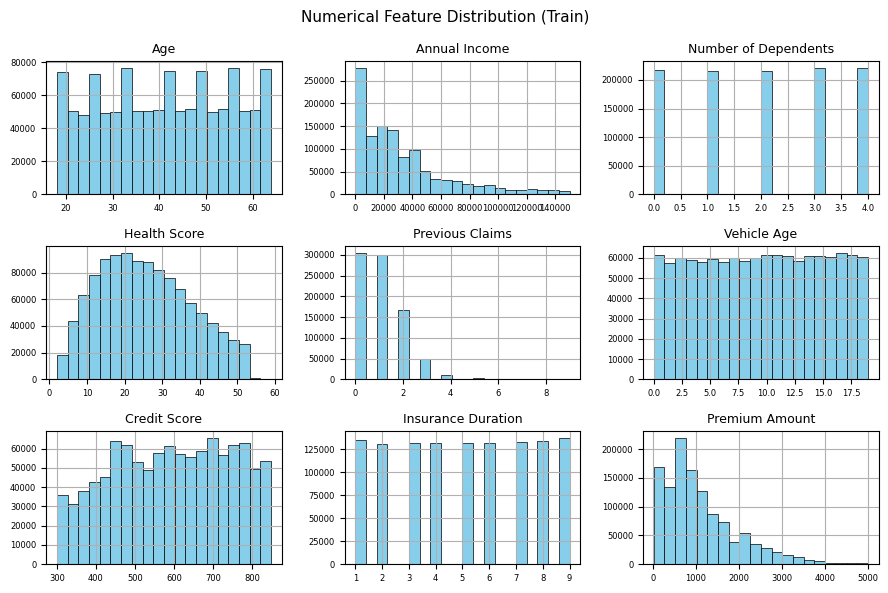

In [8]:
plot_feature_distribution(train.select_dtypes("float64"), title = "Numerical Feature Distribution (Train)")

number of columns : 9
num rows = 3, num cols = 3


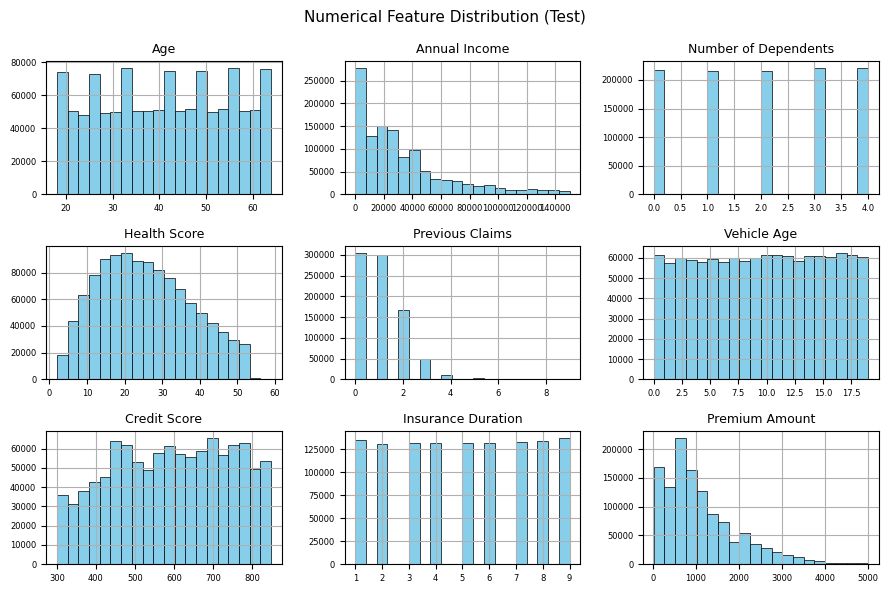

In [9]:
plot_feature_distribution(train.select_dtypes("float64"), title = "Numerical Feature Distribution (Test)")

number of columns : 10
num rows = 3, num cols = 4


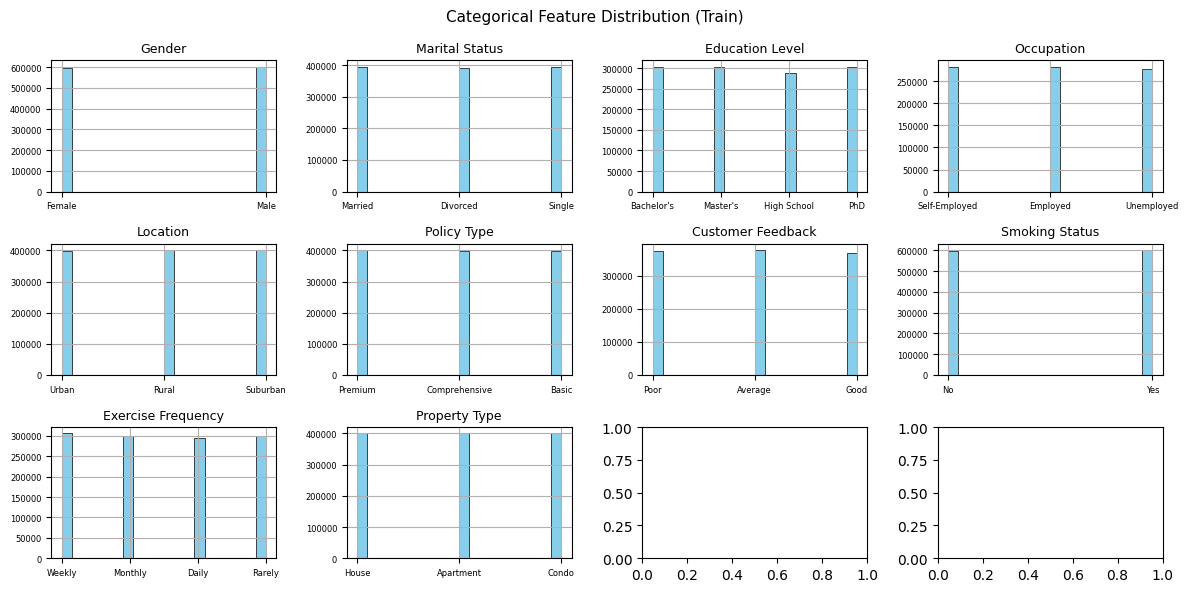

In [10]:
plot_feature_distribution(train.select_dtypes("object").drop(columns = ["Policy Start Date"]), title = "Categorical Feature Distribution (Train)")

number of columns : 10
num rows = 3, num cols = 4


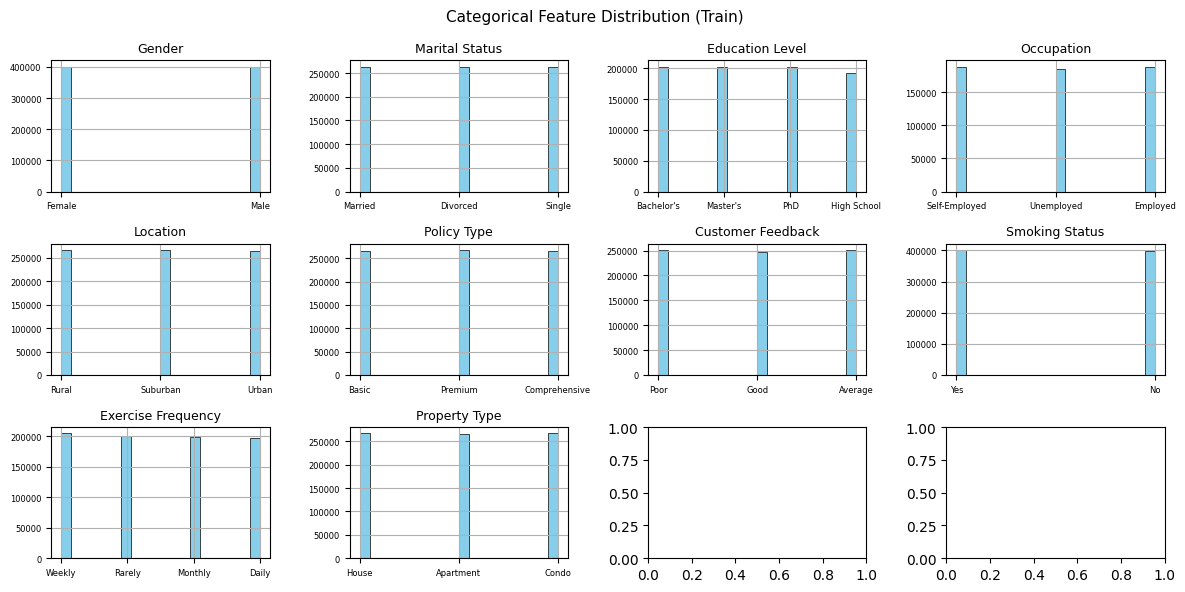

In [11]:
plot_feature_distribution(test.select_dtypes("object").drop(columns = ["Policy Start Date"]), title = "Categorical Feature Distribution (Train)")

### Missing Values

The distribution of missing values is similar across train and test set. Therefore, the imputation strategy across train and test should be consistent

In [12]:
# Highlight rows with more than 5% missing values
def highlight_high_missing_values(val, threshold):
    if float(val.strip('%')) > threshold:
        color = 'red'
    elif float(val.strip('%')) <= threshold and float(val.strip('%')) > 0:
        color = 'yellow'
    else:
        color = None
    return f'color: {color}'

def inspectMissingValues(df, threshold = 5):
    '''
    Calculate the number and portion of missing values in each column of df
    highlight those with missing value portion > (threshold %)
    '''
    # Count of missing values
    missing_values_count = df.isnull().sum()

    # Proportion of missing values
    total_observations = df.shape[0]
    missing_values_proportion = missing_values_count / total_observations

    
    missing_data_summary = pd.DataFrame({
        'Missing Values Count': missing_values_count,
        'Proportion (%)': missing_values_proportion.map(lambda x: f'{x:.4%}'),
        'Data Type': df.dtypes
    })
    
    missing_data_summary = missing_data_summary.style.applymap(lambda val: highlight_high_missing_values(val, threshold), subset=['Proportion (%)'])

    return missing_data_summary

In [13]:
inspectMissingValues(train)

,Missing Values Count,Proportion (%),Data Type
id,0,0.0000%,int64
Age,18705,1.5588%,float64
Gender,0,0.0000%,object
Annual Income,44949,3.7457%,float64
Marital Status,18529,1.5441%,object
Number of Dependents,109672,9.1393%,float64
Education Level,0,0.0000%,object
Occupation,358075,29.8396%,object
Health Score,74076,6.1730%,float64
Location,0,0.0000%,object


In [14]:
inspectMissingValues(test)

,Missing Values Count,Proportion (%),Data Type
id,0,0.0000%,int64
Age,12489,1.5611%,float64
Gender,0,0.0000%,object
Annual Income,29860,3.7325%,float64
Marital Status,12336,1.5420%,object
Number of Dependents,73130,9.1412%,float64
Education Level,0,0.0000%,object
Occupation,239125,29.8906%,object
Health Score,49449,6.1811%,float64
Location,0,0.0000%,object


# Impute Missing Value

The imputation method should 
- preserve the distribution of original data
- be stable
- be quick to implement

Median is used for numerical features and an indicator class is used for categorical features.

In [15]:
for num_col in train.select_dtypes('float64').columns:
    if num_col == "Premium Amount":
        continue
    
    train[num_col].fillna(value = train[num_col].median(), inplace = True)
    test[num_col].fillna(value = train[num_col].median(), inplace = True)

for cat_col in train.select_dtypes('object').columns:
    train[cat_col].fillna("Unknown", inplace=True)
    test[cat_col].fillna("Unknown", inplace=True)

In [16]:
train.isnull().sum()

id                      0
Age                     0
Gender                  0
Annual Income           0
Marital Status          0
Number of Dependents    0
Education Level         0
Occupation              0
Health Score            0
Location                0
Policy Type             0
Previous Claims         0
Vehicle Age             0
Credit Score            0
Insurance Duration      0
Policy Start Date       0
Customer Feedback       0
Smoking Status          0
Exercise Frequency      0
Property Type           0
Premium Amount          0
dtype: int64

In [17]:
test.isnull().sum()

id                      0
Age                     0
Gender                  0
Annual Income           0
Marital Status          0
Number of Dependents    0
Education Level         0
Occupation              0
Health Score            0
Location                0
Policy Type             0
Previous Claims         0
Vehicle Age             0
Credit Score            0
Insurance Duration      0
Policy Start Date       0
Customer Feedback       0
Smoking Status          0
Exercise Frequency      0
Property Type           0
dtype: int64

# Feature Transformation

In [18]:
train['Log Premium Amount'] = np.log(train['Premium Amount']+1)

### Skewness of numerical features

`Annual Income` and `Health Score` are positively skewed, apply one of these three transformations:
- Logarithmic
- Square Root
- Box-Cox

In [19]:
train['Log Annual Income'] = np.log(train['Annual Income'])
train['SQRT Annual Income'] = np.sqrt(train['Annual Income'])
train['Boxcox Annual Income'], annual_income_lmbda =  boxcox(train['Annual Income'])

test['Log Annual Income'] = np.log(test['Annual Income'])
test['SQRT Annual Income'] = np.sqrt(test['Annual Income'])
test['Boxcox Annual Income'], _ =  boxcox(test['Annual Income'])

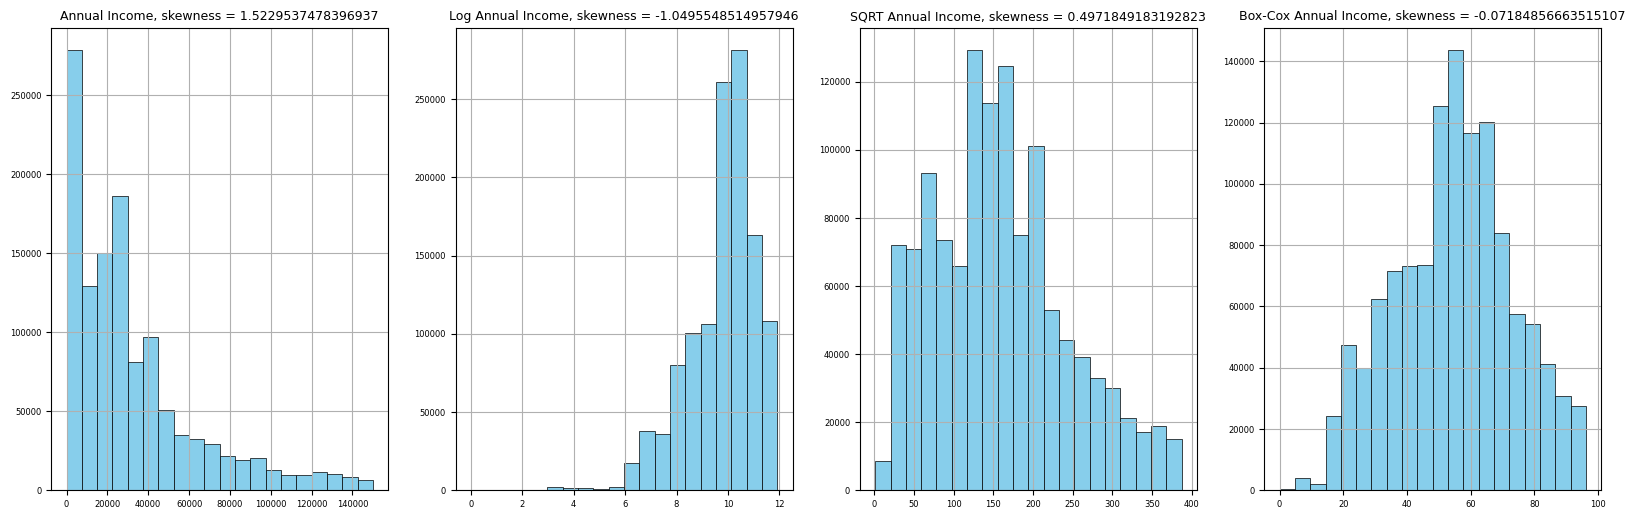

In [20]:
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(20,6))

train['Annual Income'].hist(ax=axes[0], bins=20, color='skyblue', edgecolor='black', linewidth=0.5)
axes[0].set_title(f'Annual Income, skewness = {train["Annual Income"].skew()}', fontsize=9)
axes[0].tick_params(axis='both', which='major', labelsize=6)

train['Log Annual Income'].hist(ax=axes[1], bins=20, color='skyblue', edgecolor='black', linewidth=0.5)
axes[1].set_title(f'Log Annual Income, skewness = {train["Log Annual Income"].skew()}', fontsize=9)
axes[1].tick_params(axis='both', which='major', labelsize=6)

train['SQRT Annual Income'].hist(ax=axes[2], bins=20, color='skyblue', edgecolor='black', linewidth=0.5)
axes[2].set_title(f'SQRT Annual Income, skewness = {train["SQRT Annual Income"].skew()}', fontsize=9)
axes[2].tick_params(axis='both', which='major', labelsize=6)

train['Boxcox Annual Income'].hist(ax=axes[3], bins=20, color='skyblue', edgecolor='black', linewidth=0.5)
axes[3].set_title(f'Box-Cox Annual Income, skewness = {train["Boxcox Annual Income"].skew()}', fontsize=9)
axes[3].tick_params(axis='both', which='major', labelsize=6)

In [21]:
train['Log Health Score'] = np.log(train['Health Score'])
train['SQRT Health Score'] = np.sqrt(train['Health Score'])
train['Boxcox Health Score'], health_score_lmbda =  boxcox(train['Health Score']) 

test['Log Health Score'] = np.log(test['Health Score'])
test['SQRT Health Score'] = np.sqrt(test['Health Score'])
test['Boxcox Health Score'], _ =  boxcox(test['Health Score']) 

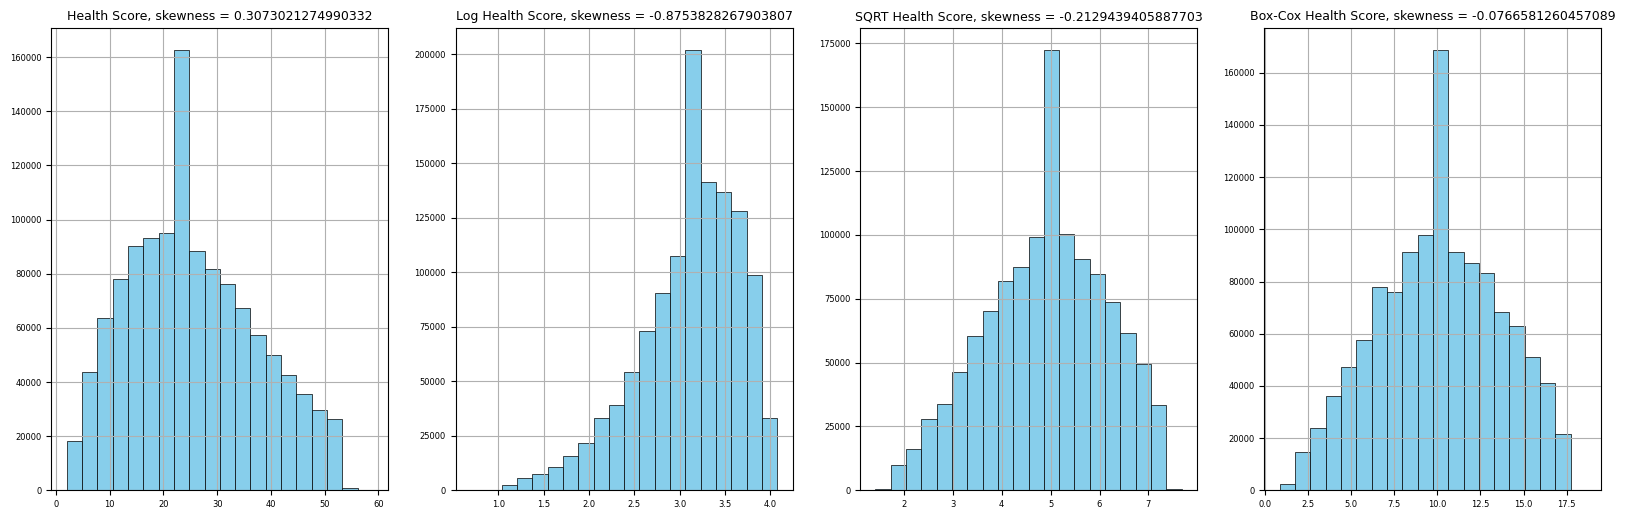

In [22]:
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(20,6))

train['Health Score'].hist(ax=axes[0], bins=20, color='skyblue', edgecolor='black', linewidth=0.5)
axes[0].set_title(f'Health Score, skewness = {train["Health Score"].skew()}', fontsize=9)
axes[0].tick_params(axis='both', which='major', labelsize=6)

train['Log Health Score'].hist(ax=axes[1], bins=20, color='skyblue', edgecolor='black', linewidth=0.5)
axes[1].set_title(f'Log Health Score, skewness = {train["Log Health Score"].skew()}', fontsize=9)
axes[1].tick_params(axis='both', which='major', labelsize=6)

train['SQRT Health Score'].hist(ax=axes[2], bins=20, color='skyblue', edgecolor='black', linewidth=0.5)
axes[2].set_title(f'SQRT Health Score, skewness = {train["SQRT Health Score"].skew()}', fontsize=9)
axes[2].tick_params(axis='both', which='major', labelsize=6)

train['Boxcox Health Score'].hist(ax=axes[3], bins=20, color='skyblue', edgecolor='black', linewidth=0.5)
axes[3].set_title(f'Box-Cox Health Score, skewness = {train["Boxcox Health Score"].skew()}', fontsize=9)
axes[3].tick_params(axis='both', which='major', labelsize=6)

### Periodic Encoding for `Policy Start Date`

In [23]:
# Example
datetime = train['Policy Start Date'].values[0]
print(f'Raw format: {datetime}')

datetime = pd.to_datetime(datetime).date()
print(f'Transformed: {datetime}')

print(f'year: {datetime.year}, month: {datetime.month}, day: {datetime.day}')

Raw format: 2023-12-23 15:21:39.134960
Transformed: 2023-12-23
year: 2023, month: 12, day: 23


In [24]:
for df in [train, test]:
    df['Policy Start Date'] = pd.to_datetime(df['Policy Start Date'])
    df['Policy Start Date'] = df['Policy Start Date'].apply(lambda dt: dt.date())

    df['Policy Start Date_Year'] = df['Policy Start Date'].apply(lambda dt: dt.year)

    df['Policy Start Date_Month'] = df['Policy Start Date'].apply(lambda dt: dt.month)
    df['Policy Start Date_Month_sin'] = np.sin(2 * np.pi * df['Policy Start Date_Month'] / 12)
    df['Policy Start Date_Month_cos'] = np.cos(2 * np.pi * df['Policy Start Date_Month'] / 12)

    df['Policy Start Date_Day'] = df['Policy Start Date'].apply(lambda dt: dt.day)

### Encode Categorical Features

In [25]:
cat_columns = train.select_dtypes(include = "object").columns

for col in cat_columns:
    print(f'{col}: {train[col].dropna().unique()}')

Gender: ['Female' 'Male']
Marital Status: ['Married' 'Divorced' 'Single' 'Unknown']
Education Level: ["Bachelor's" "Master's" 'High School' 'PhD']
Occupation: ['Self-Employed' 'Unknown' 'Employed' 'Unemployed']
Location: ['Urban' 'Rural' 'Suburban']
Policy Type: ['Premium' 'Comprehensive' 'Basic']
Policy Start Date: [datetime.date(2023, 12, 23) datetime.date(2023, 6, 12)
 datetime.date(2023, 9, 30) ... datetime.date(2019, 11, 21)
 datetime.date(2023, 5, 4) datetime.date(2022, 1, 28)]
Customer Feedback: ['Poor' 'Average' 'Good' 'Unknown']
Smoking Status: ['No' 'Yes']
Exercise Frequency: ['Weekly' 'Monthly' 'Daily' 'Rarely']
Property Type: ['House' 'Apartment' 'Condo']


The following features are ordinal:
- `Education Level`
- `Customer Feedback`
- `Smoking Status`
- `Exercise Frequency`

Use integer to encode these features

In [26]:
def encode_ordinal_feature(column, cat_order, df):
    encoder = OrdinalEncoder(categories=[cat_order], handle_unknown='use_encoded_value', unknown_value = np.nan)
    df[f'{column}_ordinal encoding'] = encoder.fit_transform(df[[column]]).reshape(-1,)

In [27]:
ordinal_columns_to_order = {'Education Level': ['High School', "Bachelor's","Master's", "PhD"], 
                            'Customer Feedback': ['Poor','Average','Good'],
                            'Smoking Status': ['No','Yes'],
                            "Exercise Frequency": ['Rarely', 'Daily', 'Weekly','Monthly']}


In [28]:
for col in ordinal_columns_to_order:
    encode_ordinal_feature(col, ordinal_columns_to_order[col], train)
    encode_ordinal_feature(col, ordinal_columns_to_order[col], test)

The following features are nominal:
- `Gender`
- `Marital Status`
- `Occupation`
- `Location`
- `Policy Type`
- `Property Type`

In [29]:
nominal_cat_columns = ['Gender', 'Marital Status', 'Occupation', 'Location', 'Policy Type', 'Property Type']
for col in nominal_cat_columns:
    train = pd.concat([train, pd.get_dummies(train[col], dtype='float64', prefix=col, drop_first=True)], axis = 1)
    test = pd.concat([test, pd.get_dummies(test[col], dtype='float64', prefix=col, drop_first=True)], axis = 1)

train.head()

,id,Age,Gender,Annual Income,Marital Status,Number of Dependents,Education Level,Occupation,Health Score,Location,...,Marital Status_Unknown,Occupation_Self-Employed,Occupation_Unemployed,Occupation_Unknown,Location_Suburban,Location_Urban,Policy Type_Comprehensive,Policy Type_Premium,Property Type_Condo,Property Type_House
0,0,19.0,Female,10049.0,Married,1.0,Bachelor's,Self-Employed,22.598761,Urban,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
1,1,39.0,Female,31678.0,Divorced,3.0,Master's,Unknown,15.569731,Rural,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
2,2,23.0,Male,25602.0,Divorced,3.0,High School,Self-Employed,47.177549,Suburban,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
3,3,21.0,Male,141855.0,Married,2.0,Bachelor's,Unknown,10.938144,Rural,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,21.0,Male,39651.0,Single,1.0,Bachelor's,Self-Employed,20.376094,Rural,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0


# Model Training

In [30]:
X_columns_transformed = [ 
        'Age',
        'Credit Score',
        'Vehicle Age',
        'Insurance Duration',
        'Number of Dependents',
        'Previous Claims',
        'Log Annual Income',
        'Log Health Score',
        'Policy Start Date_Year','Policy Start Date_Month_sin', 'Policy Start Date_Month_cos', 'Policy Start Date_Day',
        'Education Level_ordinal encoding',
        'Customer Feedback_ordinal encoding', 
        'Smoking Status_ordinal encoding',
        'Exercise Frequency_ordinal encoding', 
        'Gender_Female', 'Gender_Male',
        'Marital Status_Divorced', 'Marital Status_Married','Marital Status_Single', 'Occupation_Employed',
        'Occupation_Self-Employed', 'Occupation_Unemployed','Occupation_Unknown', 
        'Location_Rural', 'Location_Suburban','Location_Urban', 
        'Policy Type_Basic', 'Policy Type_Comprehensive','Policy Type_Premium', 
        'Property Type_Apartment', 'Property Type_Condo','Property Type_House'
       ]

In [31]:
X_sample = train[[col for col in X_columns_transformed if col in train.columns]]
Y_sample = train['Log Premium Amount']

X_test = test[[col for col in X_columns_transformed if col in test.columns]]

In [32]:
X_train, X_valid, Y_train, Y_valid = train_test_split(X_sample, Y_sample, test_size=0.2, random_state=RANDOM_SEED)

### Hyperparameter Tuning

In [33]:
def objective_lgbm(trial):
    params = {
        'boosting_type': 'gbdt',
        'objective': 'regression',
        'metric': 'rmse',
        'n_estimators': trial.suggest_int('n_estimators', 300, 1500),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),
        'num_leaves': trial.suggest_int('num_leaves', 20, 150),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0),
        'device': 'gpu',
        'gpu_platform_id': 0,
        'gpu_device_id': 0,
        'verbose': -1,
    }

    model = LGBMRegressor(**params)
    model.fit(X_train, Y_train, 
              eval_set=[(X_valid, Y_valid)], 
              eval_metric='rmse', 
              callbacks=[early_stopping(stopping_rounds=200)])
    preds = model.predict(X_valid)
    return mean_squared_error(Y_valid, preds)**0.5
    
study_lgbm = optuna.create_study(direction='minimize')
study_lgbm.optimize(objective_lgbm, n_trials=50)
print("Best parameters for LightGBM:", study_lgbm.best_params)

[I 2024-12-31 19:44:17,904] A new study created in memory with name: no-name-aa53cd15-aa14-4a8f-a266-99b77b72b61c


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[43]	valid_0's rmse: 1.04902


[I 2024-12-31 19:44:32,069] Trial 0 finished with value: 1.049021721407271 and parameters: {'n_estimators': 700, 'learning_rate': 0.12700988877672972, 'num_leaves': 133, 'max_depth': 10, 'min_child_samples': 12, 'subsample': 0.7511263460421942, 'colsample_bytree': 0.878527134275795, 'reg_alpha': 7.977067511815613, 'reg_lambda': 3.774330704187964}. Best is trial 0 with value: 1.049021721407271.


Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[588]	valid_0's rmse: 1.05247


[I 2024-12-31 19:44:55,073] Trial 1 finished with value: 1.0524733422964037 and parameters: {'n_estimators': 588, 'learning_rate': 0.019199007335463678, 'num_leaves': 65, 'max_depth': 5, 'min_child_samples': 57, 'subsample': 0.5179526688464341, 'colsample_bytree': 0.5488361988639292, 'reg_alpha': 1.8600127695917974, 'reg_lambda': 9.948250060598342}. Best is trial 0 with value: 1.049021721407271.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[50]	valid_0's rmse: 1.04897


[I 2024-12-31 19:45:03,543] Trial 2 finished with value: 1.0489666363666466 and parameters: {'n_estimators': 967, 'learning_rate': 0.1257622950323994, 'num_leaves': 93, 'max_depth': 10, 'min_child_samples': 45, 'subsample': 0.9598217820964112, 'colsample_bytree': 0.8851921047950998, 'reg_alpha': 6.1708996162970156, 'reg_lambda': 3.193058329930984}. Best is trial 2 with value: 1.0489666363666466.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[157]	valid_0's rmse: 1.05088


[I 2024-12-31 19:45:12,921] Trial 3 finished with value: 1.0508818705677874 and parameters: {'n_estimators': 1336, 'learning_rate': 0.18160602878688947, 'num_leaves': 36, 'max_depth': 10, 'min_child_samples': 31, 'subsample': 0.8053841466625776, 'colsample_bytree': 0.5113117532094699, 'reg_alpha': 9.416489017232516, 'reg_lambda': 6.4948457952715355}. Best is trial 2 with value: 1.0489666363666466.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[897]	valid_0's rmse: 1.05225


[I 2024-12-31 19:45:42,730] Trial 4 finished with value: 1.0522494413252383 and parameters: {'n_estimators': 1483, 'learning_rate': 0.1237430357499541, 'num_leaves': 73, 'max_depth': 4, 'min_child_samples': 82, 'subsample': 0.7681160694959424, 'colsample_bytree': 0.6179001236062824, 'reg_alpha': 3.3522461003508752, 'reg_lambda': 0.46319752222143573}. Best is trial 2 with value: 1.0489666363666466.


Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[1184]	valid_0's rmse: 1.05374


[I 2024-12-31 19:46:11,479] Trial 5 finished with value: 1.0537372895062267 and parameters: {'n_estimators': 1241, 'learning_rate': 0.10207583286994272, 'num_leaves': 148, 'max_depth': 3, 'min_child_samples': 94, 'subsample': 0.5149192431848821, 'colsample_bytree': 0.8810558799097511, 'reg_alpha': 6.43665938546566, 'reg_lambda': 1.3923867347006786}. Best is trial 2 with value: 1.0489666363666466.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[160]	valid_0's rmse: 1.05045


[I 2024-12-31 19:46:23,506] Trial 6 finished with value: 1.050446287181487 and parameters: {'n_estimators': 671, 'learning_rate': 0.17366081570241554, 'num_leaves': 53, 'max_depth': 5, 'min_child_samples': 72, 'subsample': 0.6221758051108232, 'colsample_bytree': 0.988036723165421, 'reg_alpha': 7.622026098101946, 'reg_lambda': 0.8969250978198405}. Best is trial 2 with value: 1.0489666363666466.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[412]	valid_0's rmse: 1.04905


[I 2024-12-31 19:46:37,196] Trial 7 finished with value: 1.0490533220833302 and parameters: {'n_estimators': 1081, 'learning_rate': 0.08368697279251824, 'num_leaves': 25, 'max_depth': 9, 'min_child_samples': 71, 'subsample': 0.8974557600940611, 'colsample_bytree': 0.8598138626826344, 'reg_alpha': 6.0443521682781425, 'reg_lambda': 9.589759025409075}. Best is trial 2 with value: 1.0489666363666466.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[46]	valid_0's rmse: 1.04929


[I 2024-12-31 19:46:47,096] Trial 8 finished with value: 1.049294683031265 and parameters: {'n_estimators': 807, 'learning_rate': 0.14594585034454471, 'num_leaves': 141, 'max_depth': 10, 'min_child_samples': 86, 'subsample': 0.9034469858920801, 'colsample_bytree': 0.7521145029063733, 'reg_alpha': 7.637581628221964, 'reg_lambda': 8.620073762307788}. Best is trial 2 with value: 1.0489666363666466.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[109]	valid_0's rmse: 1.04993


[I 2024-12-31 19:46:59,271] Trial 9 finished with value: 1.0499252705051998 and parameters: {'n_estimators': 1053, 'learning_rate': 0.1425205462604815, 'num_leaves': 76, 'max_depth': 6, 'min_child_samples': 14, 'subsample': 0.8401710147987661, 'colsample_bytree': 0.8140896587685238, 'reg_alpha': 0.7783135515737379, 'reg_lambda': 1.0803693606739406}. Best is trial 2 with value: 1.0489666363666466.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[104]	valid_0's rmse: 1.04888


[I 2024-12-31 19:47:10,258] Trial 10 finished with value: 1.0488777994042957 and parameters: {'n_estimators': 316, 'learning_rate': 0.06970376368938644, 'num_leaves': 104, 'max_depth': 12, 'min_child_samples': 38, 'subsample': 0.9818133560353441, 'colsample_bytree': 0.9696663913817385, 'reg_alpha': 4.09938450706902, 'reg_lambda': 3.8809381854215537}. Best is trial 10 with value: 1.0488777994042957.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[97]	valid_0's rmse: 1.04883


[I 2024-12-31 19:47:21,685] Trial 11 finished with value: 1.0488330627042992 and parameters: {'n_estimators': 305, 'learning_rate': 0.05877265623110335, 'num_leaves': 107, 'max_depth': 12, 'min_child_samples': 40, 'subsample': 0.9897682546006452, 'colsample_bytree': 0.9854409772596593, 'reg_alpha': 3.981169741872232, 'reg_lambda': 3.743455702545409}. Best is trial 11 with value: 1.0488330627042992.


Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[115]	valid_0's rmse: 1.04896


[I 2024-12-31 19:47:33,293] Trial 12 finished with value: 1.0489624133819755 and parameters: {'n_estimators': 301, 'learning_rate': 0.0546730570665474, 'num_leaves': 105, 'max_depth': 12, 'min_child_samples': 37, 'subsample': 0.9769039681778441, 'colsample_bytree': 0.998113097446625, 'reg_alpha': 3.9897508333991327, 'reg_lambda': 5.729647341440275}. Best is trial 11 with value: 1.0488330627042992.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[129]	valid_0's rmse: 1.04891


[I 2024-12-31 19:47:45,613] Trial 13 finished with value: 1.0489087556219185 and parameters: {'n_estimators': 331, 'learning_rate': 0.05666694709615672, 'num_leaves': 114, 'max_depth': 12, 'min_child_samples': 27, 'subsample': 0.9918746714604337, 'colsample_bytree': 0.9482354595766175, 'reg_alpha': 3.309884070632201, 'reg_lambda': 3.735003933035238}. Best is trial 11 with value: 1.0488330627042992.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[272]	valid_0's rmse: 1.04918


[I 2024-12-31 19:48:05,780] Trial 14 finished with value: 1.0491828813824784 and parameters: {'n_estimators': 501, 'learning_rate': 0.030131445039118666, 'num_leaves': 121, 'max_depth': 12, 'min_child_samples': 56, 'subsample': 0.6655729081481985, 'colsample_bytree': 0.7160519528346212, 'reg_alpha': 4.702364585180804, 'reg_lambda': 2.571865897013388}. Best is trial 11 with value: 1.0488330627042992.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[138]	valid_0's rmse: 1.04911


[I 2024-12-31 19:48:18,509] Trial 15 finished with value: 1.0491146310532808 and parameters: {'n_estimators': 464, 'learning_rate': 0.07142629960662582, 'num_leaves': 94, 'max_depth': 8, 'min_child_samples': 43, 'subsample': 0.913483537615919, 'colsample_bytree': 0.9496434675639096, 'reg_alpha': 1.9107475642126301, 'reg_lambda': 4.978264303579381}. Best is trial 11 with value: 1.0488330627042992.


Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[241]	valid_0's rmse: 1.04915


[I 2024-12-31 19:48:35,435] Trial 16 finished with value: 1.0491499848658616 and parameters: {'n_estimators': 428, 'learning_rate': 0.041830388481673114, 'num_leaves': 124, 'max_depth': 11, 'min_child_samples': 23, 'subsample': 0.8672001968258503, 'colsample_bytree': 0.6986388314193843, 'reg_alpha': 2.3045991123976117, 'reg_lambda': 7.220250168499955}. Best is trial 11 with value: 1.0488330627042992.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[140]	valid_0's rmse: 1.04944


[I 2024-12-31 19:48:50,871] Trial 17 finished with value: 1.049443564065292 and parameters: {'n_estimators': 804, 'learning_rate': 0.08770352892725577, 'num_leaves': 108, 'max_depth': 7, 'min_child_samples': 50, 'subsample': 0.6738280163042667, 'colsample_bytree': 0.8006702556685104, 'reg_alpha': 5.044078848435412, 'reg_lambda': 4.617247034113744}. Best is trial 11 with value: 1.0488330627042992.


Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[538]	valid_0's rmse: 1.04909


[I 2024-12-31 19:49:18,461] Trial 18 finished with value: 1.049087983306836 and parameters: {'n_estimators': 538, 'learning_rate': 0.015449382712223132, 'num_leaves': 90, 'max_depth': 8, 'min_child_samples': 6, 'subsample': 0.9444185775074988, 'colsample_bytree': 0.9302646628126987, 'reg_alpha': 0.46431873262534085, 'reg_lambda': 2.496697625571307}. Best is trial 11 with value: 1.0488330627042992.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[118]	valid_0's rmse: 1.0489


[I 2024-12-31 19:49:30,708] Trial 19 finished with value: 1.048902657832641 and parameters: {'n_estimators': 397, 'learning_rate': 0.06299218092368307, 'num_leaves': 102, 'max_depth': 11, 'min_child_samples': 64, 'subsample': 0.8367233867094375, 'colsample_bytree': 0.8132794895380017, 'reg_alpha': 4.975480271220823, 'reg_lambda': 7.437624495822755}. Best is trial 11 with value: 1.0488330627042992.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[76]	valid_0's rmse: 1.04961


[I 2024-12-31 19:49:41,281] Trial 20 finished with value: 1.0496089607084826 and parameters: {'n_estimators': 654, 'learning_rate': 0.09843453214044734, 'num_leaves': 132, 'max_depth': 11, 'min_child_samples': 37, 'subsample': 0.9377589779212676, 'colsample_bytree': 0.6503983317872521, 'reg_alpha': 2.897116145826584, 'reg_lambda': 2.3113093843913264}. Best is trial 11 with value: 1.0488330627042992.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[137]	valid_0's rmse: 1.0489


[I 2024-12-31 19:49:53,545] Trial 21 finished with value: 1.0489032681067174 and parameters: {'n_estimators': 380, 'learning_rate': 0.06608360154444634, 'num_leaves': 103, 'max_depth': 11, 'min_child_samples': 63, 'subsample': 0.9979200585019732, 'colsample_bytree': 0.8112189480585179, 'reg_alpha': 4.815546833232476, 'reg_lambda': 7.478907782834369}. Best is trial 11 with value: 1.0488330627042992.


Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[214]	valid_0's rmse: 1.04889


[I 2024-12-31 19:50:06,266] Trial 22 finished with value: 1.0488869323218653 and parameters: {'n_estimators': 302, 'learning_rate': 0.04039808092311259, 'num_leaves': 79, 'max_depth': 12, 'min_child_samples': 67, 'subsample': 0.835435783053405, 'colsample_bytree': 0.924757707107025, 'reg_alpha': 4.208204233631251, 'reg_lambda': 5.913670009827387}. Best is trial 11 with value: 1.0488330627042992.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[218]	valid_0's rmse: 1.0489


[I 2024-12-31 19:50:21,301] Trial 23 finished with value: 1.0488978345804267 and parameters: {'n_estimators': 541, 'learning_rate': 0.0388160137125817, 'num_leaves': 80, 'max_depth': 12, 'min_child_samples': 48, 'subsample': 0.8750347497440328, 'colsample_bytree': 0.9240828525530166, 'reg_alpha': 3.9703818915096494, 'reg_lambda': 5.837237349686495}. Best is trial 11 with value: 1.0488330627042992.


Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[193]	valid_0's rmse: 1.04898


[I 2024-12-31 19:50:33,145] Trial 24 finished with value: 1.0489798340609529 and parameters: {'n_estimators': 322, 'learning_rate': 0.04425374207580741, 'num_leaves': 59, 'max_depth': 9, 'min_child_samples': 21, 'subsample': 0.7976199312815059, 'colsample_bytree': 0.9967911558168453, 'reg_alpha': 3.976385582620215, 'reg_lambda': 4.235706923614134}. Best is trial 11 with value: 1.0488330627042992.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[89]	valid_0's rmse: 1.04894


[I 2024-12-31 19:50:41,530] Trial 25 finished with value: 1.048937815364452 and parameters: {'n_estimators': 457, 'learning_rate': 0.08645023653862648, 'num_leaves': 47, 'max_depth': 12, 'min_child_samples': 34, 'subsample': 0.7174604618613794, 'colsample_bytree': 0.961297921323804, 'reg_alpha': 5.780161930829348, 'reg_lambda': 5.666117733752937}. Best is trial 11 with value: 1.0488330627042992.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[82]	valid_0's rmse: 1.04903


[I 2024-12-31 19:50:51,754] Trial 26 finished with value: 1.0490272623353334 and parameters: {'n_estimators': 305, 'learning_rate': 0.07564620558330415, 'num_leaves': 88, 'max_depth': 9, 'min_child_samples': 71, 'subsample': 0.9408962835754338, 'colsample_bytree': 0.9126017087558239, 'reg_alpha': 2.9261885875762172, 'reg_lambda': 3.3554664310698072}. Best is trial 11 with value: 1.0488330627042992.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[286]	valid_0's rmse: 1.04883


[I 2024-12-31 19:51:08,950] Trial 27 finished with value: 1.0488264373330654 and parameters: {'n_estimators': 767, 'learning_rate': 0.03140655970757771, 'num_leaves': 67, 'max_depth': 11, 'min_child_samples': 40, 'subsample': 0.5935654599429223, 'colsample_bytree': 0.8399966002070455, 'reg_alpha': 5.369634148022504, 'reg_lambda': 6.45117304459973}. Best is trial 27 with value: 1.0488264373330654.


Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[865]	valid_0's rmse: 1.04887


[I 2024-12-31 19:51:50,234] Trial 28 finished with value: 1.0488666559561892 and parameters: {'n_estimators': 901, 'learning_rate': 0.01055905654771767, 'num_leaves': 67, 'max_depth': 11, 'min_child_samples': 40, 'subsample': 0.5699074234200714, 'colsample_bytree': 0.844198532930229, 'reg_alpha': 7.132743011761986, 'reg_lambda': 1.929298956507313}. Best is trial 27 with value: 1.0488264373330654.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[558]	valid_0's rmse: 1.04898


[I 2024-12-31 19:52:20,182] Trial 29 finished with value: 1.0489814592252409 and parameters: {'n_estimators': 799, 'learning_rate': 0.015659081638409022, 'num_leaves': 69, 'max_depth': 10, 'min_child_samples': 16, 'subsample': 0.5710742880490063, 'colsample_bytree': 0.8500086468734088, 'reg_alpha': 7.14456314360252, 'reg_lambda': 1.8625437359466448}. Best is trial 27 with value: 1.0488264373330654.


Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[790]	valid_0's rmse: 1.04912


[I 2024-12-31 19:52:45,828] Trial 30 finished with value: 1.04911565412197 and parameters: {'n_estimators': 888, 'learning_rate': 0.029316567420938053, 'num_leaves': 36, 'max_depth': 11, 'min_child_samples': 43, 'subsample': 0.5810963662295507, 'colsample_bytree': 0.7672910981675621, 'reg_alpha': 9.536779308432017, 'reg_lambda': 3.068322749547664}. Best is trial 27 with value: 1.0488264373330654.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[328]	valid_0's rmse: 1.0489


[I 2024-12-31 19:53:04,479] Trial 31 finished with value: 1.0488984338725023 and parameters: {'n_estimators': 962, 'learning_rate': 0.02712479378634508, 'num_leaves': 60, 'max_depth': 11, 'min_child_samples': 39, 'subsample': 0.5740378262230892, 'colsample_bytree': 0.8421749560429556, 'reg_alpha': 8.554762955455853, 'reg_lambda': 4.233202893748742}. Best is trial 27 with value: 1.0488264373330654.


Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[656]	valid_0's rmse: 1.04893


[I 2024-12-31 19:53:46,767] Trial 32 finished with value: 1.0489333041251667 and parameters: {'n_estimators': 767, 'learning_rate': 0.010751707408665045, 'num_leaves': 115, 'max_depth': 10, 'min_child_samples': 29, 'subsample': 0.5444603762776113, 'colsample_bytree': 0.906190646765358, 'reg_alpha': 5.562676898378514, 'reg_lambda': 5.010760388330332}. Best is trial 27 with value: 1.0488264373330654.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[181]	valid_0's rmse: 1.04886


[I 2024-12-31 19:54:00,368] Trial 33 finished with value: 1.0488550897318112 and parameters: {'n_estimators': 597, 'learning_rate': 0.05037682268063944, 'num_leaves': 85, 'max_depth': 11, 'min_child_samples': 54, 'subsample': 0.640891236308918, 'colsample_bytree': 0.9614617107177671, 'reg_alpha': 6.507696481809877, 'reg_lambda': 0.11749989702243013}. Best is trial 27 with value: 1.0488264373330654.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[154]	valid_0's rmse: 1.04899


[I 2024-12-31 19:54:12,410] Trial 34 finished with value: 1.048986837737249 and parameters: {'n_estimators': 609, 'learning_rate': 0.051993140327160486, 'num_leaves': 64, 'max_depth': 9, 'min_child_samples': 54, 'subsample': 0.6267948355763892, 'colsample_bytree': 0.8903018069768498, 'reg_alpha': 6.521160688695305, 'reg_lambda': 0.40799484051237556}. Best is trial 27 with value: 1.0488264373330654.


Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[891]	valid_0's rmse: 1.0489


[I 2024-12-31 19:54:42,290] Trial 35 finished with value: 1.0488952657715787 and parameters: {'n_estimators': 897, 'learning_rate': 0.02564691184934534, 'num_leaves': 48, 'max_depth': 11, 'min_child_samples': 49, 'subsample': 0.6082250722364348, 'colsample_bytree': 0.8629438997117234, 'reg_alpha': 8.368433241032632, 'reg_lambda': 0.056846034584526514}. Best is trial 27 with value: 1.0488264373330654.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[198]	valid_0's rmse: 1.04902


[I 2024-12-31 19:54:56,887] Trial 36 finished with value: 1.0490229102205029 and parameters: {'n_estimators': 750, 'learning_rate': 0.0490623394222864, 'num_leaves': 84, 'max_depth': 10, 'min_child_samples': 56, 'subsample': 0.7074964314615342, 'colsample_bytree': 0.7898673271760759, 'reg_alpha': 7.001690713644694, 'reg_lambda': 1.272943588786928}. Best is trial 27 with value: 1.0488264373330654.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[443]	valid_0's rmse: 1.04954


[I 2024-12-31 19:55:27,385] Trial 37 finished with value: 1.04953687093773 and parameters: {'n_estimators': 1115, 'learning_rate': 0.03550872331535708, 'num_leaves': 97, 'max_depth': 7, 'min_child_samples': 42, 'subsample': 0.5046404132476839, 'colsample_bytree': 0.7084875079943322, 'reg_alpha': 8.843753425409869, 'reg_lambda': 1.826744493129223}. Best is trial 27 with value: 1.0488264373330654.


Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[686]	valid_0's rmse: 1.04956


[I 2024-12-31 19:55:57,951] Trial 38 finished with value: 1.0495556651984326 and parameters: {'n_estimators': 724, 'learning_rate': 0.020330635323517886, 'num_leaves': 71, 'max_depth': 10, 'min_child_samples': 31, 'subsample': 0.5395155334703434, 'colsample_bytree': 0.5995758183333042, 'reg_alpha': 6.721697784431254, 'reg_lambda': 1.8365898437920272}. Best is trial 27 with value: 1.0488264373330654.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[50]	valid_0's rmse: 1.04895


[I 2024-12-31 19:56:04,350] Trial 39 finished with value: 1.0489523861144072 and parameters: {'n_estimators': 980, 'learning_rate': 0.19197762901744458, 'num_leaves': 38, 'max_depth': 11, 'min_child_samples': 79, 'subsample': 0.6513116741113687, 'colsample_bytree': 0.8327520046458283, 'reg_alpha': 5.490338435250605, 'reg_lambda': 6.759690497810704}. Best is trial 27 with value: 1.0488264373330654.


Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[624]	valid_0's rmse: 1.05476


[I 2024-12-31 19:56:18,566] Trial 40 finished with value: 1.0547646024703448 and parameters: {'n_estimators': 625, 'learning_rate': 0.11216273791556386, 'num_leaves': 84, 'max_depth': 3, 'min_child_samples': 60, 'subsample': 0.7062456993629084, 'colsample_bytree': 0.8735293294670852, 'reg_alpha': 7.803895177803977, 'reg_lambda': 0.6740188745080551}. Best is trial 27 with value: 1.0488264373330654.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[147]	valid_0's rmse: 1.04884


[I 2024-12-31 19:56:31,519] Trial 41 finished with value: 1.0488447840579853 and parameters: {'n_estimators': 844, 'learning_rate': 0.061522506719315265, 'num_leaves': 98, 'max_depth': 12, 'min_child_samples': 47, 'subsample': 0.6009936432162757, 'colsample_bytree': 0.9669298734071723, 'reg_alpha': 6.254788914476029, 'reg_lambda': 3.398852472721756}. Best is trial 27 with value: 1.0488264373330654.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[360]	valid_0's rmse: 1.04884


[I 2024-12-31 19:56:55,118] Trial 42 finished with value: 1.048840616312596 and parameters: {'n_estimators': 702, 'learning_rate': 0.020840134002158776, 'num_leaves': 98, 'max_depth': 12, 'min_child_samples': 47, 'subsample': 0.6006675203524576, 'colsample_bytree': 0.9733420851745168, 'reg_alpha': 6.164039069609139, 'reg_lambda': 2.9798431541935795}. Best is trial 27 with value: 1.0488264373330654.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[85]	valid_0's rmse: 1.04892


[I 2024-12-31 19:57:05,381] Trial 43 finished with value: 1.0489216595217161 and parameters: {'n_estimators': 690, 'learning_rate': 0.07821729469752735, 'num_leaves': 95, 'max_depth': 12, 'min_child_samples': 47, 'subsample': 0.6039710173239481, 'colsample_bytree': 0.9740949545056513, 'reg_alpha': 6.1651169715828, 'reg_lambda': 2.946361084085308}. Best is trial 27 with value: 1.0488264373330654.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[101]	valid_0's rmse: 1.04897


[I 2024-12-31 19:57:17,229] Trial 44 finished with value: 1.0489653132879768 and parameters: {'n_estimators': 846, 'learning_rate': 0.05687461483470132, 'num_leaves': 110, 'max_depth': 12, 'min_child_samples': 52, 'subsample': 0.6368661117156355, 'colsample_bytree': 0.9446585863125221, 'reg_alpha': 5.351838543500133, 'reg_lambda': 8.499354581924628}. Best is trial 27 with value: 1.0488264373330654.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[126]	valid_0's rmse: 1.04889


[I 2024-12-31 19:57:29,280] Trial 45 finished with value: 1.048886133762431 and parameters: {'n_estimators': 581, 'learning_rate': 0.061634053953272934, 'num_leaves': 99, 'max_depth': 12, 'min_child_samples': 33, 'subsample': 0.5939867762944844, 'colsample_bytree': 0.980088458983707, 'reg_alpha': 5.971138728764299, 'reg_lambda': 3.6995677234700217}. Best is trial 27 with value: 1.0488264373330654.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[54]	valid_0's rmse: 1.04903


[I 2024-12-31 19:57:38,718] Trial 46 finished with value: 1.0490328039186498 and parameters: {'n_estimators': 1435, 'learning_rate': 0.09568645164591133, 'num_leaves': 118, 'max_depth': 12, 'min_child_samples': 45, 'subsample': 0.7476316604490031, 'colsample_bytree': 0.8999804568278285, 'reg_alpha': 4.556699184679652, 'reg_lambda': 5.365449799933144}. Best is trial 27 with value: 1.0488264373330654.


Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[677]	valid_0's rmse: 1.0504


[I 2024-12-31 19:58:04,351] Trial 47 finished with value: 1.0503984718980464 and parameters: {'n_estimators': 681, 'learning_rate': 0.04653947492531622, 'num_leaves': 126, 'max_depth': 5, 'min_child_samples': 25, 'subsample': 0.5375536773375094, 'colsample_bytree': 0.9655214404531163, 'reg_alpha': 6.387490397405452, 'reg_lambda': 6.4001283002807545}. Best is trial 27 with value: 1.0488264373330654.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[36]	valid_0's rmse: 1.04898


[I 2024-12-31 19:58:11,509] Trial 48 finished with value: 1.048978047396481 and parameters: {'n_estimators': 1020, 'learning_rate': 0.1642947886470424, 'num_leaves': 76, 'max_depth': 10, 'min_child_samples': 59, 'subsample': 0.6622940071219814, 'colsample_bytree': 0.9974316027017198, 'reg_alpha': 3.5616932202262954, 'reg_lambda': 4.530453177564473}. Best is trial 27 with value: 1.0488264373330654.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[433]	valid_0's rmse: 1.04889


[I 2024-12-31 19:58:34,034] Trial 49 finished with value: 1.048885687048373 and parameters: {'n_estimators': 1221, 'learning_rate': 0.03655157763797466, 'num_leaves': 88, 'max_depth': 11, 'min_child_samples': 100, 'subsample': 0.5536007101696832, 'colsample_bytree': 0.9392080498848152, 'reg_alpha': 5.329755386857879, 'reg_lambda': 3.4099558866489805}. Best is trial 27 with value: 1.0488264373330654.


Best parameters for LightGBM: {'n_estimators': 767, 'learning_rate': 0.03140655970757771, 'num_leaves': 67, 'max_depth': 11, 'min_child_samples': 40, 'subsample': 0.5935654599429223, 'colsample_bytree': 0.8399966002070455, 'reg_alpha': 5.369634148022504, 'reg_lambda': 6.45117304459973}


In [34]:
study_lgbm.best_params

{'n_estimators': 767,
 'learning_rate': 0.03140655970757771,
 'num_leaves': 67,
 'max_depth': 11,
 'min_child_samples': 40,
 'subsample': 0.5935654599429223,
 'colsample_bytree': 0.8399966002070455,
 'reg_alpha': 5.369634148022504,
 'reg_lambda': 6.45117304459973}

In [35]:
def objective_cat(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 2000, 4000),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'depth': trial.suggest_int('depth', 4, 10),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-8, 5.0),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0.0, 1.0),
        'task_type': 'GPU',
        'devices': '0',
    }

    model = CatBoostRegressor(**params, verbose=0)
    model.fit(X_train, Y_train, eval_set=(X_valid, Y_valid), early_stopping_rounds=200)
    preds = model.predict(X_valid)
    return mean_squared_error(Y_valid, preds)**0.5

study_cat = optuna.create_study(direction='minimize')
study_cat.optimize(objective_cat, n_trials=50)
print("Best parameters for CatBoost:", study_cat.best_params)

[I 2024-12-31 19:58:34,144] A new study created in memory with name: no-name-d58d9a7b-6d4d-4424-aa7e-2af0b1d06be4
[I 2024-12-31 19:58:43,321] Trial 0 finished with value: 1.0492691658831592 and parameters: {'iterations': 3939, 'learning_rate': 0.07908345078127106, 'depth': 9, 'l2_leaf_reg': 4.341777783364753, 'bagging_temperature': 0.18360498848454332}. Best is trial 0 with value: 1.0492691658831592.
[I 2024-12-31 19:58:59,738] Trial 1 finished with value: 1.0514447429213771 and parameters: {'iterations': 2350, 'learning_rate': 0.08250613185379059, 'depth': 4, 'l2_leaf_reg': 0.32865891201577735, 'bagging_temperature': 0.10868526481842544}. Best is trial 0 with value: 1.0492691658831592.
[I 2024-12-31 19:59:07,829] Trial 2 finished with value: 1.0495960599399898 and parameters: {'iterations': 3958, 'learning_rate': 0.07385679897494901, 'depth': 7, 'l2_leaf_reg': 3.4193647380266503, 'bagging_temperature': 0.614598257909768}. Best is trial 0 with value: 1.0492691658831592.
[I 2024-12-31 1

Best parameters for CatBoost: {'iterations': 2651, 'learning_rate': 0.016606579641090455, 'depth': 9, 'l2_leaf_reg': 1.0183442770333628, 'bagging_temperature': 0.2574347808304466}


In [36]:
study_cat.best_params

{'iterations': 2651,
 'learning_rate': 0.016606579641090455,
 'depth': 9,
 'l2_leaf_reg': 1.0183442770333628,
 'bagging_temperature': 0.2574347808304466}

### Cross Validation for Voting Regressor

In [37]:
kf = KFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)
best_voting_model = None
lowest_error = np.inf

splits = kf.split(train)

for fold, (train_idx, valid_idx) in enumerate(splits):
    print(f"Fold {fold + 1}")
    X_train_split, X_valid_split = X_sample.iloc[train_idx], X_sample.iloc[valid_idx]
    Y_train_split, Y_valid_split = Y_sample.iloc[train_idx], Y_sample.iloc[valid_idx]

    # LightGBM model
    lgbm_model = LGBMRegressor(**study_lgbm.best_params, device='gpu', gpu_platform_id=0, gpu_device_id=0, verbose=-1)

    # CatBoost model
    cat_model = CatBoostRegressor(**study_cat.best_params, verbose=False, task_type= 'GPU')

    # Voting Regressor
    voting_model = VotingRegressor(
        estimators=[
            ('lgbm', lgbm_model),
            ('cat', cat_model),
        ]
    )

    voting_model.fit(X_train_split, Y_train_split)
    prediction = voting_model.predict(X_valid_split)
    fold_rmsle = mean_squared_error(Y_valid_split, prediction)**0.5
    print(f"Fold {fold + 1} RMSLE: {fold_rmsle}")

    if fold_rmsle < lowest_error:
        lowest_error = fold_rmsle
        best_voting_model = voting_model
        print("Update best voting model")

Fold 1
Fold 1 RMSLE: 1.0487652703013912
Update best voting model
Fold 2
Fold 2 RMSLE: 1.0493706600481663
Fold 3
Fold 3 RMSLE: 1.0494759777082134
Fold 4
Fold 4 RMSLE: 1.0458655673317059
Update best voting model
Fold 5
Fold 5 RMSLE: 1.044851385909039
Update best voting model


### Inference

In [38]:
log_prem = best_voting_model.predict(X_test)
log_prem

array([6.57367955, 6.6717204 , 6.67973909, ..., 6.69538168, 6.66378453,
       6.63432951])

In [39]:
prem = np.expm1(log_prem)
prem

array([714.99955538, 788.75312568, 795.11137527, ..., 807.66252626,
       782.51055274, 759.76880983])

In [40]:
test['Premium Amount'] = prem
res = test[['id', 'Premium Amount']]

In [41]:
res.head()

,id,Premium Amount
0,1200000,714.999555
1,1200001,788.753126
2,1200002,795.111375
3,1200003,790.101422
4,1200004,766.243609


In [42]:
res.to_csv('submission.csv', index = False)